In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_theme(style='whitegrid')
df = pd.read_csv('CollegePlacement.csv')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
# Overview of data
print('Basic Info')
df.info()

df.describe()

Basic Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   College_ID              10000 non-null  object 
 1   IQ                      10000 non-null  int64  
 2   Prev_Sem_Result         10000 non-null  float64
 3   CGPA                    10000 non-null  float64
 4   Academic_Performance    10000 non-null  int64  
 5   Internship_Experience   10000 non-null  object 
 6   Extra_Curricular_Score  10000 non-null  int64  
 7   Communication_Skills    10000 non-null  int64  
 8   Projects_Completed      10000 non-null  int64  
 9   Placement               10000 non-null  object 
dtypes: float64(2), int64(5), object(3)
memory usage: 781.4+ KB


,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Extra_Curricular_Score,Communication_Skills,Projects_Completed
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,99.471800,7.535673,7.532379,5.546400,4.970900,5.561800,2.513400
std,15.053101,1.447519,1.470141,2.873477,3.160103,2.900866,1.715959
min,41.000000,5.000000,4.540000,1.000000,0.000000,1.000000,0.000000
25%,89.000000,6.290000,6.290000,3.000000,2.000000,3.000000,1.000000
50%,99.000000,7.560000,7.550000,6.000000,5.000000,6.000000,3.000000
75%,110.000000,8.790000,8.770000,8.000000,8.000000,8.000000,4.000000
max,158.000000,10.000000,10.460000,10.000000,10.000000,10.000000,5.000000


In [4]:
# Data cleaning
missing_values = df.isnull().sum()
print(missing_values)
# No missing values

College_ID                0
IQ                        0
Prev_Sem_Result           0
CGPA                      0
Academic_Performance      0
Internship_Experience     0
Extra_Curricular_Score    0
Communication_Skills      0
Projects_Completed        0
Placement                 0
dtype: int64


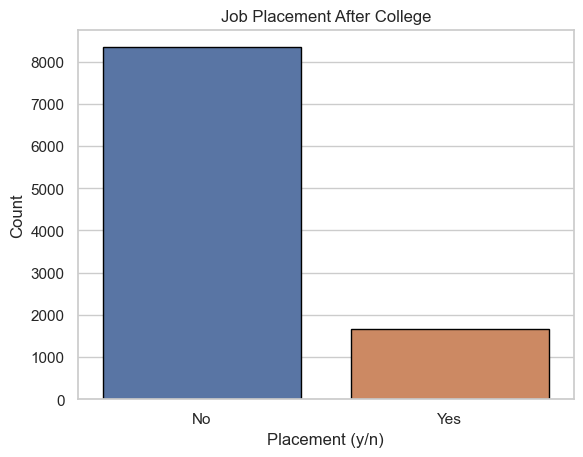

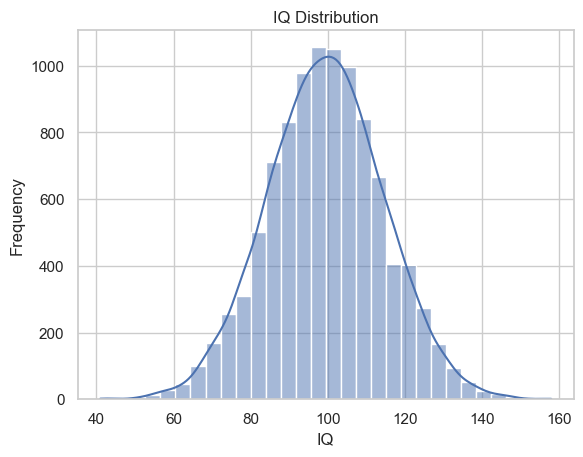

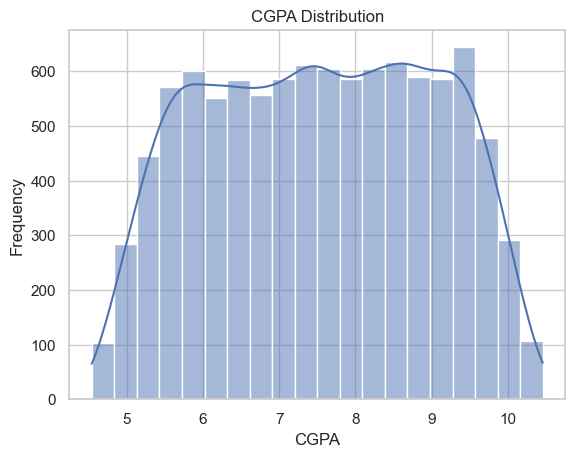

In [5]:
# Preliminary Analysis

# Histogram of Job Placements
plt.figure()
sns.countplot(x = 'Placement', data = df, palette='deep', edgecolor='black')
plt.title('Job Placement After College')
plt.xlabel('Placement (y/n)')
plt.ylabel('Count')
plt.show()

# IQ Distribution
plt.figure()
sns.histplot(df['IQ'], bins = 30, kde = True)
plt.title('IQ Distribution')
plt.xlabel('IQ')
plt.ylabel('Frequency')
plt.show()
# almost perfect bell shape!

# Cumulative GPA Distribution
plt.figure()
sns.histplot(df['CGPA'], bins = 20, kde = True)
plt.title('CGPA Distribution')
plt.xlabel('CGPA')
plt.ylabel('Frequency')
plt.show()



In [6]:
# Preparing for linear regression
# Transforming all data to numeric types
df["College_ID"] = df["College_ID"].map(lambda a: int(a[3:]))
df["Internship_Experience"] = df["Internship_Experience"].map({"Yes": 1, "No": 0})
df["Placement"] = df["Placement"].map({"Yes": 1, "No": 0})

df.head()

,College_ID,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement
0,30,107,6.61,6.28,8,0,8,8,4,0
1,61,97,5.52,5.37,8,0,7,8,0,0
2,36,109,5.36,5.83,9,0,3,1,1,0
3,55,122,5.47,5.75,6,1,1,6,1,0
4,4,96,7.91,7.69,7,0,8,10,2,0


# Logistic Regression (GLM based on Bernoulli's distribution)
1. Probability Distribution Model:

    $P(Y=y;p)=p^y (1-p)^{1-y}$

2. Likelihood:
    
    $L(\mathbf{p};\mathbf{y})=\prod_{i=1}^N P(Y=y_i;p_i)$

3. Log-likelihood:


   $\mathcal{L}(\mathbf{p};\mathbf{y})=\sum_{i=1}^N [y_i \ln(p_i) + (1-y_i)\ln(1-p_i)]$
4. Modeling step:

    Let $\ln(\frac{p}{1-p})=\mathbf{a}^T \mathbf{x}$; this constrains $p$ to be in $[0,1]$

5. Gradient of log-likelihood for gradient descent:
   
    $\nabla \mathcal{L}(\mathbf{a};X, \mathbf{y})=\sum_{i=1}^N [y_i \mathbf{x}_i - \frac{\mathbf{x}_i}{1+\exp(-\mathbf{a}^T \mathbf{x}_i)}]=\sum_{i=1}^N [\mathbf{x}_i(y_i - \sigma(\mathbf{a}^T \mathbf{x}_i))] = X^T (\mathbf{y} - \sigma(X \mathbf{a})$

In [12]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [17]:
def ll_grad(y, a, X):
    """
    Returns the gradient of the log-likelihood function
    """
    preds = sigmoid(X @ a)
    return X.T @ (y - preds)

In [ ]:

def log_likelihood(X, y, a):
    """
    Returns the probability of the event (job placement) given the features and parameters
    """
    preds = sigmoid(X @ a)
    epsilon = 1e-15
    preds = np.clip(preds, epsilon, 1 - epsilon)
    return np.sum(y * np.log(preds) + (1 - y) * np.log(1 - preds))

Epoch 0: Log-Likelihood -5543.80
Epoch 100: Log-Likelihood -5410.29
Epoch 200: Log-Likelihood -5284.23
Epoch 300: Log-Likelihood -5165.13
Epoch 400: Log-Likelihood -5052.57
Epoch 500: Log-Likelihood -4946.09
Epoch 600: Log-Likelihood -4845.32
Epoch 700: Log-Likelihood -4749.86
Epoch 800: Log-Likelihood -4659.38
Epoch 900: Log-Likelihood -4573.53

Final Weights (a): [-2.95418737e-01  1.25499795e-03  9.35931316e-02  9.31079131e-02
  9.46556310e-02 -4.68966645e-03  1.96832058e-05 -2.14393945e-03
  1.08229141e-01  7.26040624e-02]


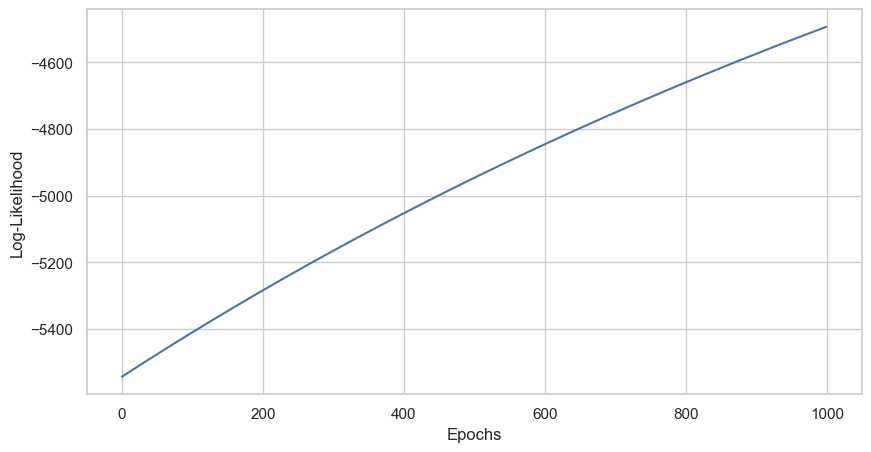

Test Set Accuracy: 89.70%


In [19]:
# Separating data (x = questions, y = yes/no to job placement)
X_raw = df.drop('Placement', axis=1).values
y = df['Placement'].values

# Setting aside 20% of data for testing
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

# Centering
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Adding intercept term
X_train_final = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_final = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

# Training via Gradient Ascent
learning_rate = 0.001
epochs = 1000
m, n = X_train_final.shape
a = np.zeros(n)
history = []

for i in range(epochs):
    gradient = ll_grad(y_train, a, X_train_final)

    a += learning_rate * (gradient / m)  # Normalize by sample size for stability

    ll = log_likelihood(X_train_final, y_train, a)
    history.append(ll)
    
    if i % 100 == 0:
        print(f"Epoch {i}: Log-Likelihood {ll:.2f}")

print(f"\nFinal Weights (a): {a}")

# Plotting restults
plt.figure(figsize=(10, 5))
plt.plot(history)
plt.xlabel("Epochs")
plt.ylabel("Log-Likelihood")
plt.grid(True)
plt.show()

def predict(X, a, threshold=0.5):
    probs = sigmoid(X @ a)
    return (probs >= threshold).astype(int)

y_pred = predict(X_test_final, a)
acc = np.mean(y_pred == y_test)
print(f"Test Set Accuracy: {acc * 100:.2f}%")